In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

from funcsigs import signature
import recmetrics

In [2]:
#평점 3점 이상만
db=pd.read_csv("D:/2021 파일들/1학기 과제 파일들/캡스톤/data/moviekk.csv")


ratings = pd.read_csv('D:/2021 파일들/1학기 과제 파일들/캡스톤/data/ratings.csv')
rate=ratings
ratings = ratings.query('rating >=3')

ratings.reset_index(drop=True, inplace=True)

In [3]:
#100명 이상의 투표
n=1000
users = ratings["userId"].value_counts()
users = users[users>n].index.tolist()

In [4]:
ratings = ratings.query('userId in @users')


print(ratings.shape)
ratings.head(3)

(85747, 4)


,userId,movieId,rating,timestamp
56832,741,1,4.5,1397350892
56833,741,2,3.0,1120109650
56834,741,3,3.5,1453787958


In [5]:
rated_movies = ratings["movieId"].tolist()

movies = pd.read_csv('D:/2021 파일들/1학기 과제 파일들/캡스톤/data/moviedbs.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)


print(movies)

movies = movies["genres"].str.split("|", expand=True)
movies.reset_index(inplace=True)
print(movies)


movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1])

movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
movies.head()



         Unnamed: 0             title  \
movieId                                 
1                 0  Toy Story (1995)   
1                 1  Toy Story (1995)   
1                 2  Toy Story (1995)   
1                 3  Toy Story (1995)   
1                 4  Toy Story (1995)   
...             ...               ...   
174055       100516    Dunkirk (2017)   
174055       100517    Dunkirk (2017)   
174055       100518    Dunkirk (2017)   
174055       100519    Dunkirk (2017)   
174055       100520    Dunkirk (2017)   

                                              genres  userId  rating  \
movieId                                                                
1        Adventure|Animation|Children|Comedy|Fantasy       1     4.0   
1        Adventure|Animation|Children|Comedy|Fantasy       5     4.0   
1        Adventure|Animation|Children|Comedy|Fantasy       7     4.5   
1        Adventure|Animation|Children|Comedy|Fantasy      15     2.5   
1        Adventure|Animation|Child

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


C:\Users\rha45\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


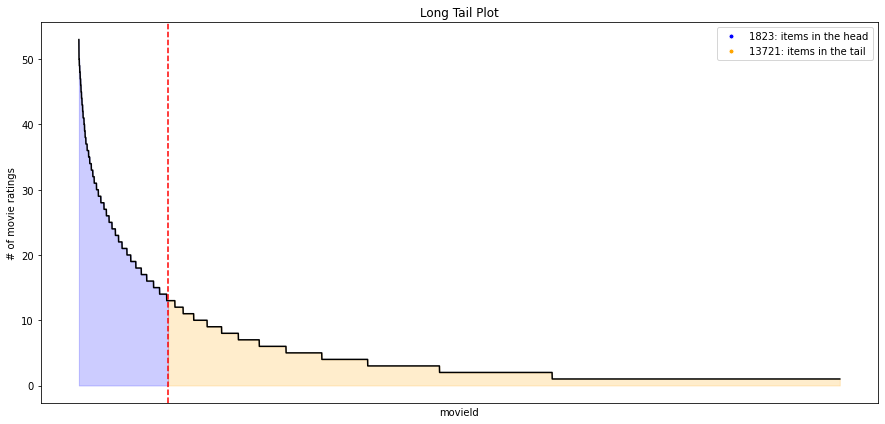

In [6]:
#희소성과 인기 편향을 중심으로 한 그래프
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

In [7]:
#collaborative filter recommender
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [8]:
#surprise 사용 위해 데이터 포맷
algo = SVD()
algo.fit(trainset)

In [9]:
#train svd recommender
test = algo.test(testset)
test = pd.DataFrame(test)

test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
mdb=test
test.head()

,userId,movieId,actual,cf_predictions
0,2885,2857,3.5,4.008780
1,5829,902,3.0,3.389744
2,2520,2944,3.5,4.079301
3,8659,2417,3.0,3.386003
4,7457,112171,3.5,3.465712


In [10]:
#mse와 rmse로 모델 비교
print("MSE: ", recmetrics.mse(test.actual, test.cf_predictions))
print("RMSE: ", recmetrics.rmse(test.actual, test.cf_predictions))

MSE:  0.2787094037775281
RMSE:  0.5279293549117421


In [11]:
#예상이 되는 평점으로 매트릭스 만들기
cf_model = test.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)

In [12]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [13]:
#448번의 예측값
get_users_predictions(741, 10, cf_model)

[912, 1213, 1704, 6016, 1617, 48516, 1250, 3671, 47, 1253]

In [14]:
test = test.copy().groupby('userId', as_index=False)['movieId'].agg({'actual': (lambda x: list(set(x)))})

In [15]:
test = test.set_index("userId")

In [16]:
#print(test[test.index==741])
l1=[]
l1=test.iloc[0]['actual']
print(len(l1))
#print(test[test.index==741]['actual'])
cnt=0
#test1['movie']=test[test.index==741]['actual'].apply(lambda x:x.split(','))
#print(test1['movie'])

601


In [17]:
#모든 userid에 대한 영화추천 10개 collaborative 위주
cf_recs = [] = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    cf_recs.append(cf_predictions)
        
test['cf_predictions'] = cf_recs
test.head()

,actual,cf_predictions
userId,,
741,"[122882, 3, 2052, 40966, 2058, 12, 106508, 206...","[912, 1213, 1704, 6016, 1617, 48516, 1250, 367..."
836,"[2048, 40962, 2, 122886, 122892, 4118, 6166, 2...","[1196, 750, 2571, 1208, 541, 46578, 1240, 1270..."
1652,"[1029, 6, 4102, 1035, 2571, 78349, 1552, 15720...","[4993, 296, 2571, 4973, 1222, 2959, 1266, 912,..."
1846,"[69122, 26631, 6664, 1033, 4105, 2571, 55820, ...","[1198, 260, 2571, 1617, 7361, 923, 1233, 750, ..."
2313,"[2050, 515, 1028, 1029, 1031, 4104, 2571, 4621...","[1196, 1284, 4993, 1204, 1221, 1272, 2571, 593..."


In [18]:
#가장 잘나가는 영화 10개
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

pop_recs = []
for user in test.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()

,actual,cf_predictions,pop_predictions
userId,,,
741,"[122882, 3, 2052, 40966, 2058, 12, 106508, 206...","[912, 1213, 1704, 6016, 1617, 48516, 1250, 367...","[1270, 2571, 480, 593, 318, 1, 2716, 1198, 124..."
836,"[2048, 40962, 2, 122886, 122892, 4118, 6166, 2...","[1196, 750, 2571, 1208, 541, 46578, 1240, 1270...","[1270, 2571, 480, 593, 318, 1, 2716, 1198, 124..."
1652,"[1029, 6, 4102, 1035, 2571, 78349, 1552, 15720...","[4993, 296, 2571, 4973, 1222, 2959, 1266, 912,...","[1270, 2571, 480, 593, 318, 1, 2716, 1198, 124..."
1846,"[69122, 26631, 6664, 1033, 4105, 2571, 55820, ...","[1198, 260, 2571, 1617, 7361, 923, 1233, 750, ...","[1270, 2571, 480, 593, 318, 1, 2716, 1198, 124..."
2313,"[2050, 515, 1028, 1029, 1031, 4104, 2571, 4621...","[1196, 1284, 4993, 1204, 1221, 1272, 2571, 593...","[1270, 2571, 480, 593, 318, 1, 2716, 1198, 124..."


In [19]:
#10개의 무작위 영화
ran_recs = []
for user in test.index:
    random_predictions = ratings.movieId.sample(10).values.tolist()
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs


In [20]:
#장르의 비율


cm=CountVectorizer().fit_transform(db['genre'])

cs=cosine_similarity(cm)
#print(cs)
def get_recommendations_ratio(userid):
    sim_scores = list(enumerate(cs[userid]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) #내림차순
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movie_indices
person=[]
print(test.index)
for user in range(0,test.index.size):
    print(get_recommendations_ratio(user))
for user in range(0,test.index.size):
    person.append(get_recommendations_ratio(user))


Int64Index([  741,   836,  1652,  1846,  2313,  2520,  2531,  2547,  2639,
             2885,  2975,  3140,  3437,  3771,  3780,  4160,  4294,  4323,
             4387,  4916,  4964,  5523,  5620,  5641,  5829,  5915,  5953,
             6188,  6222,  6513,  6812,  6914,  7107,  7155,  7238,  7417,
             7457,  8273,  8287,  8622,  8659,  8667,  9040,  9164,  9279,
             9488,  9788, 10082, 10086, 10132, 10223, 10250, 10637],
           dtype='int64', name='userId')
[20, 117, 558, 228, 189, 137, 568, 505, 136, 87]
[332, 12, 507, 222, 286, 43, 165, 500, 128, 215]
[150, 194, 191, 112, 202, 38, 114, 20, 335, 330]
[518, 187, 193, 202, 219, 442, 577, 609, 398, 578]
[477, 84, 5, 58, 119, 134, 86, 576, 330, 478]
[86, 58, 233, 178, 150, 330, 238, 534, 119, 39]
[436, 218, 15, 81, 157, 457, 236, 188, 386, 172]
[137, 79, 184, 109, 191, 228, 28, 312, 568, 189]
[237, 85, 250, 505, 35, 117, 175, 136, 508, 163]
[274, 120, 168, 229, 75, 136, 87, 49, 180, 236]
[258, 216, 203, 82, 240, 144

In [21]:
gratio_recs=[]

compare=[]
for i in range(0,len(person)):
    gratio=[]
    for user_id in person[i]:
        gratio_prediction=rate[rate['userId']==user_id]
        gratio_prediction=gratio_prediction.sort_values(by=['timestamp'], axis=0,ascending=False )
        for h in range(0,2):
            if len(gratio_prediction)>2:
                gratio_prediction_0=gratio_prediction.iloc[h]["movieId"]
                #print(gratio_prediction_0)
                rate1=rate[(rate['userId']==user_id)&(rate['movieId']==gratio_prediction_0)]
                for x in rate1['rating']:
                    if x>2.5:
                        dic=dict()
                        dic['predicted']=x
                        dic['truth']=1
                        compare.append(dic)
                    else:
                        dic=dict()
                        dic['predicted']=x
                        dic['truth']=0
                        compare.append(dic)
                
            
        gratio.append(gratio_prediction_0)
    gratio_recs.append(gratio)
test['gratio_predictions']=gratio_recs
#print(compare)
        
   
        
    
   

In [22]:
for i in range(len(gratio_recs)):
    for j in range(len(gratio_recs[i])):
        gratio_recs[i][j]=int(gratio_recs[i][j])

In [23]:
test['gratio_predictions']=gratio_recs
test.head()

,actual,cf_predictions,pop_predictions,random_predictions,gratio_predictions
userId,,,,,
741,"[122882, 3, 2052, 40966, 2058, 12, 106508, 206...","[912, 1213, 1704, 6016, 1617, 48516, 1250, 367...","[1270, 2571, 480, 593, 318, 1, 2716, 1198, 124...","[3697, 91762, 5544, 1245, 2106, 6605, 33166, 7...","[155064, 2551, 653, 2657, 2581, 2253, 115149, ..."
836,"[2048, 40962, 2, 122886, 122892, 4118, 6166, 2...","[1196, 750, 2571, 1208, 541, 46578, 1240, 1270...","[1270, 2571, 480, 593, 318, 1, 2716, 1198, 124...","[93831, 2997, 99117, 42011, 150, 116937, 7846,...","[122886, 3052, 1407, 2161, 356, 1380, 4186, 81..."
1652,"[1029, 6, 4102, 1035, 2571, 78349, 1552, 15720...","[4993, 296, 2571, 4973, 1222, 2959, 1266, 912,...","[1270, 2571, 480, 593, 318, 1, 2716, 1198, 124...","[1597, 25822, 38038, 86244, 43419, 58154, 5880...","[1834, 736, 1049, 745, 783, 103688, 355, 15506..."
1846,"[69122, 26631, 6664, 1033, 4105, 2571, 55820, ...","[1198, 260, 2571, 1617, 7361, 923, 1233, 750, ...","[1270, 2571, 480, 593, 318, 1, 2716, 1198, 124...","[90960, 2471, 33834, 911, 69640, 368, 471, 558...","[808, 89864, 2387, 783, 1777, 35, 1479, 8195, ..."
2313,"[2050, 515, 1028, 1029, 1031, 4104, 2571, 4621...","[1196, 1284, 4993, 1204, 1221, 1272, 2571, 593...","[1270, 2571, 480, 593, 318, 1, 2716, 1198, 124...","[2174, 6442, 37733, 142503, 51937, 6287, 3489,...","[97921, 673, 2877, 319, 176, 1224, 3153, 2, 55..."


In [24]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()
gratio_predictions=test.gratio_predictions.values.tolist()

In [25]:
print(movies.index)

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            170907, 170937, 171631, 171759, 171763, 172547, 173145, 173209,
            173941, 174055],
           dtype='int64', name='movieId', length=8334)


In [33]:

# 실제 사람들이 본 영화 비율
#print("cm:",cm)
cc=[]
ggcm=cm.toarray()
for i in range(0,len(ggcm)):
    #print(i,">> ",ggcm[i])
    count=0
    tc=[]
    for j in ggcm[i]:
        count+=j
    #print(i,"번째", count)
    for j in ggcm[i]:
        tc.append(j/count)
    cc.append(tc)

#print(cc)

#장르 개수를 세기위해 추가.
gen=[]
for cc in movies[movies.index==0]:
    if cc not in gen:
        gen.append(cc)

gc=pd.DataFrame(None, columns=gen)

## actual 데이터에서 gratio가 hit하는 비율
actual_data=[]
counta=[]
for i in range(0,len(actual)):
    #print("확인", i, "번째")
    temp=[]
    cccc=0
    for j in actual[i]:
        temp.append(j)
        cccc+=1
    actual_data.append(j)
    counta.append(cccc)
gratio_data=[]
hit_rate=[] #<- hit 비율
genre_hitrate=[]
for i in range(0, len(gratio_predictions)):
    tmp1=[]
    count=0
    for j in gratio_predictions[i]:
        if j in actual[i]:
            #print(i,"번째에 존재하는 영화",j)
            count+=1
        tmp1.append(j)
    
    gratio_data.append(tmp1)
    #print(i,"번째 동일 개수",count, counta[i])
    #print(i,"번째 비율:",count/10) #test 셋이 추출되는 양이 때마다 다르기 때문에 10~20으로 한정하였다.
    hit_rate.append([count, counta[i], count/10])

print(len(movies))


8334


In [28]:
#단일//test로 뽑힌 영화 중 실제 사용자 시청한 장르 개수 세기.
gen=[]
for cc in movies[movies.index==0]:
    if cc not in gen:
        gen.append(cc)


exception_data=[]
cnts=pd.DataFrame(None, columns=gen)
tt=[]
for ii in gen:
    tt.append(0)

#print(cnts)

for i in range(0,10):
    cnts.loc[i]=tt
    for j in actual[i][:20]:
    #print(i,"/",j)
        for cc in movies[movies.index==j]:
            try: 
                if movies.loc[j][cc]==1:
                    #print(cc,":",movies.loc[j][cc])
                    cnts.loc[i][cc]=cnts.loc[i][cc]+1
            except:
                #print(j,"번 정보가 없습니다.")
                exception_data.append(j)
                cnts.loc[i]['(no genres listed)']+=1
                break 

#cnts를 통해 i번째 사용자의 실제 시청 영화 장르의 개수를 센다.
print(cnts)        
           
# 장르가 없는 데이터 리스트
#print(exception_data)



  (no genres listed) Action Adventure Animation Children Comedy Crime  \
0                  2      3         1         0        2      6     1   
1                  2      5         4         0        1      7     0   
2                  1      6         1         1        1      6     0   
3                  0      3         2         5        1      1     1   
4                  0      3         3         1        1      6     0   
5                  5      1         5         0        0      3     2   
6                  0      6         2         3        0      1     2   
7                  1      1         3         0        0      3     2   
8                  5      2         1         0        0      4     2   
9                  3      3         2         0        0      4     3   

  Documentary Drama Fantasy Film-Noir Horror Musical Mystery Romance Sci-Fi  \
0           1     3       0         0      0       0       1       0      0   
1           0     0       0         0 

In [34]:
gen=[]
for cc in movies[movies.index==0]:
    if cc not in gen:
        gen.append(cc)


exception_data=[]
gratio_predic=pd.DataFrame(None, columns=gen)
tt=[]
for ii in gen:
    tt.append(0)

#print(cnts)

for i in range(0,10):
    gratio_predic.loc[i]=tt
    for j in gratio_predictions[i][:20]:
    #print(i,"/",j)
        for cc in movies[movies.index==j]:
            try: 
                if movies.loc[j][cc]==1:
                    #print(cc,":",movies.loc[j][cc])
                    gratio_predic.loc[i][cc]=gratio_predic.loc[i][cc]+1
            except:
                #print(j,"번 정보가 없습니다.")
                exception_data.append(j)
                gratio_predic.loc[i]['(no genres listed)']+=1
                break 

#cnts를 통해 i번째 사용자의 실제 시청 영화 장르의 개수를 센다.
print(gratio_predic)        
           
# 장르가 없는 데이터 리스트
#print(exception_data)



  (no genres listed) Action Adventure Animation Children Comedy Crime  \
0                  0      2         0         1        0      4     0   
1                  1      3         2         0        0      4     0   
2                  0      2         0         2        1      1     2   
3                  2      1         1         1        0      4     0   
4                  0      3         2         0        0      3     1   
5                  0      2         0         0        0      4     3   
6                  0      2         0         0        0      3     2   
7                  0      3         0         0        0      6     1   
8                  0      1         0         1        1      3     1   
9                  1      2         0         1        0      3     1   

  Documentary Drama Fantasy Film-Noir Horror Musical Mystery Romance Sci-Fi  \
0           0     3       0         0      0       0       0       0      0   
1           0     0       0         0 

[[3, 601, 0.3], [2, 327, 0.2], [0, 258, 0.0], [1, 281, 0.1], [0, 260, 0.0], [0, 452, 0.0], [2, 361, 0.2], [1, 417, 0.1], [1, 256, 0.1], [1, 315, 0.1], [0, 283, 0.0], [3, 330, 0.3], [0, 354, 0.0], [1, 256, 0.1], [0, 274, 0.0], [0, 617, 0.0], [4, 530, 0.4], [1, 536, 0.1], [2, 693, 0.2], [3, 714, 0.3], [1, 265, 0.1], [0, 317, 0.0], [0, 725, 0.0], [1, 285, 0.1], [2, 487, 0.2], [2, 438, 0.2], [1, 333, 0.1], [2, 366, 0.2], [4, 302, 0.4], [0, 358, 0.0], [2, 310, 0.2], [2, 246, 0.2], [3, 313, 0.3], [0, 278, 0.0], [0, 328, 0.0], [1, 264, 0.1], [2, 221, 0.2], [1, 451, 0.1], [1, 269, 0.1], [1, 328, 0.1], [4, 2096, 0.4], [0, 514, 0.0], [1, 478, 0.1], [0, 251, 0.0], [0, 251, 0.0], [1, 492, 0.1], [2, 437, 0.2], [0, 281, 0.0], [1, 315, 0.1], [0, 438, 0.0], [1, 275, 0.1], [1, 265, 0.1], [1, 345, 0.1]]


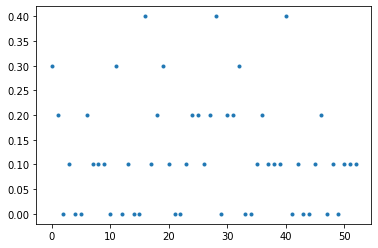

In [30]:
# 추천 인덱스별 정확도 그래프 그리기
print(hit_rate)
x=np.arange(0,len(gratio_predictions))
plt.plot(x, np.array(hit_rate)[:,2],'.')

[0.3, 0.2, 0.0, 0.1, 0.4]
[4, 10, 17, 19, 3]


<BarContainer object of 5 artists>

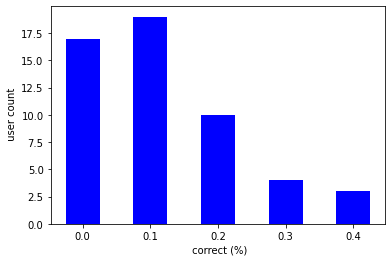

In [35]:
#비율 추천이 실제 시청영화와 맞는개수를 유저별로 카운트
y=[]
for hit in np.array(hit_rate)[:,2]:
    if hit not in y:
        y.append(hit)
print(y)
ratem=[]
for rat in y:
    ratem.append(np.array(hit_rate)[:,2].tolist().count(rat))
print(ratem)
plt.xlabel(' correct (%)')
plt.ylabel(' user count')
plt.bar(y,ratem, width=0.05,color="blue")

In [36]:

#단일//비율 추천으로 추천한 영화들의 장르 개수 세기
genrehit_rate=[]
cnts_gratio=pd.DataFrame(None, columns=gen)

#for i in range(0,10):
#cnts_gratio.loc[0]=tt
#print(cnts_gratio)
for i in range(0, 10):
    cnts_gratio.loc[i]=tt
    for j in gratio_predictions[i]:
        for cc in movies[movies.index==j]:
            try: 
                if movies.loc[j][cc]==1:
                    #print(cc,":",movies.loc[j][cc])
                    cnts_gratio.loc[i][cc]=cnts.loc[i][cc]+1
            except:
                #print(j,"번 정보가 없습니다.")
                exception_data.append(j)
                cnts_gratio.loc[i]['(no genres listed)']+=1
                break

print(cnts_gratio)
#for it in range(0,10):
    #print(cnts_gratio.iloc[it])


  (no genres listed) Action Adventure Animation Children Comedy Crime  \
0                  0      4         0         1        0      7     0   
1                  1      6         5         0        0      8     0   
2                  0      7         0         2        2      7     1   
3                  2      4         3         6        0      2     0   
4                  0      4         4         0        0      7     1   
5                  0      2         0         0        0      4     3   
6                  0      7         0         0        0      2     3   
7                  0      2         0         0        0      4     3   
8                  0      3         0         1        1      5     3   
9                  1      4         0         1        0      5     4   

  Documentary Drama Fantasy Film-Noir Horror Musical Mystery Romance Sci-Fi  \
0           0     4       0         0      0       0       0       0      0   
1           0     0       0         0 

0    3
1    5
2    6
3    3
4    3
5    1
6    6
7    1
8    2
9    3
Name: Action, dtype: object


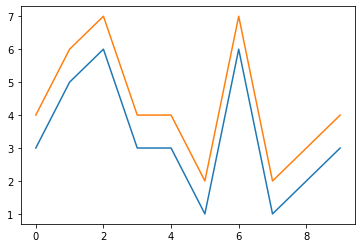

In [37]:
# 사용자와 장르의 그래프
print(cnts['Action'])

plt.plot(range(0,10), cnts[:]['Action'])
plt.plot(range(0,10), cnts_gratio[:]['Action'])

In [38]:
#그래프를 위해 새로 데이터 생성.
gen=[]
for cc in movies[movies.index==0]:
    if cc not in gen:
        gen.append(cc)
        
movies = pd.read_csv('D:/2021 파일들/1학기 과제 파일들/캡스톤/data/moviedbs.csv')
movies = movies.query('movieId in @rated_movies')

movies.drop_duplicates("movieId", inplace=True)
movies.set_index("movieId", inplace=True, drop=True)

mmo=movies

def setGenresMatrix_0(genres,gen):
    movieGenresMatrix = []
    movieGenresList = genres.split('|')
    for x in gen:
        if (x in movieGenresList):
            movieGenresMatrix.append(1)
        else:
            movieGenresMatrix.append(0) 
    return movieGenresMatrix
mmo['genresMatrix'] = movies.apply(lambda x: np.array(list(setGenresMatrix_0(x['genres'],gen))), axis=1)

In [39]:
print(mmo['genresMatrix'])

movieId
1         [0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
2         [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
3         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
4         [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...
5         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                                ...                        
172547    [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
173145    [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
173209    [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
173941    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
174055    [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
Name: genresMatrix, Length: 8334, dtype: object


In [40]:
#복수//test로 뽑힌 영화 중 실제 사용자 시청한 장르 개수 세기.



exception_data=[]
cnts=pd.DataFrame(None, columns=gen)
tt=[]
for ii in gen:
    tt.append(0)

print(cnts)

for i in range(0,10):
    cnts.loc[i]=tt
    for j in actual[i][:20]:
        #print(i,"/",j)
        #print(mmo.loc[j]['genresMatrix'])
        count=0
        try:
            for cc in mmo.loc[j]['genresMatrix']:
                if cc==1:
                    #print(cc,":",movies.loc[j][cc])
                    cnts.loc[i][count]=cnts.loc[i][count]+1
                    count+=1
                elif cc==0:
                    continue
        except:
            #print(j,"번 정보가 없습니다.")
            #exception_data.append(j)
            cnts.loc[i]['(no genres listed)']=cnts.loc[i]['(no genres listed)']+1
            break
                

#cnts를 통해 i번째 사용자의 실제 시청 영화 장르의 개수를 센다.
print(cnts)        
           
# 장르가 없는 데이터 리스트
#print(exception_data)



Empty DataFrame
Columns: [(no genres listed), Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western]
Index: []
  (no genres listed) Action Adventure Animation Children Comedy Crime  \
0                  7      5         3         3        1      0     0   
1                  6      5         4         2        0      0     0   
2                 14     11         6         3        1      0     0   
3                 20     18        12         5        2      0     0   
4                 20     17        11         3        0      0     0   
5                  7      6         2         0        0      0     0   
6                 20     17        14         7        3      0     0   
7                  9      7         5         1        1      0     0   
8                  4      3         1         1        0      0     0   
9                 10      8         7         4     

In [41]:

#복수//비율 추천으로 추천한 영화들의 장르 개수 세기
genrehit_rate=[]
cnts_gratio=pd.DataFrame(None, columns=gen)
print(cnts_gratio)
for i in range(0, 10):
    cnts_gratio.loc[i]=tt
    for j in gratio_predictions[i]:
        count=0
        try:
            for cc in mmo.loc[j]['genresMatrix']:
                if cc==1:
                    #print(cc,":",movies.loc[j][cc])
                    cnts_gratio.loc[i][count]=cnts_gratio.loc[i][count]+1
                    count+=1
        except:
            #print(j,"번 정보가 없습니다.")
            #exception_data.append(j)
            cnts_gratio.loc[i]['(no genres listed)']=cnts_gratio.loc[i]['(no genres listed)']+1
            break

print(cnts_gratio)
#for it in range(0,10):
    #print(cnts_gratio.iloc[it])


Empty DataFrame
Columns: [(no genres listed), Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western]
Index: []
  (no genres listed) Action Adventure Animation Children Comedy Crime  \
0                 10     10         5         2        0      0     0   
1                  7      6         6         3        0      0     0   
2                 10      9         6         3        1      0     0   
3                  6      5         1         1        1      0     0   
4                 10      8         6         3        1      1     0   
5                 10      9         4         2        0      0     0   
6                 10      9         4         1        0      0     0   
7                 10     10         5         1        0      0     0   
8                 10      9         6         1        0      0     0   
9                  4      1         1         0     

0     5
1     5
2    11
3    18
4    17
5     6
6    17
7     7
8     3
9     8
Name: Action, dtype: object 0    10
1     6
2     9
3     5
4     8
5     9
6     9
7    10
8     9
9     1
Name: Action, dtype: object


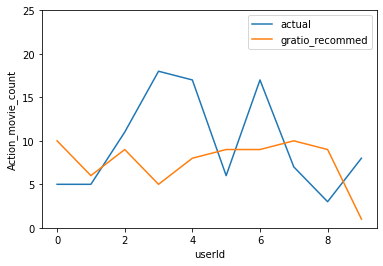

In [42]:
# 사용자와 장르의 그래프
print(cnts['Action'],cnts_gratio['Action'])
plt.ylim(0,25)
plt.xlabel('userId')
plt.ylabel('Action_movie_count')
plt.plot(range(0,10), cnts[:]['Action'])
plt.plot(range(0,10), cnts_gratio[:]['Action'])
plt.legend(['actual','gratio_recommed'])

In [43]:
# 실제 시청 영화의 장르의 비율과 추천 장르의 비율 비교
for cc in gen:
    print(cc,"장르에 대해서..")
    for x in range(0,10):
        print(cnts.loc[x][cc]/20," vs ", cnts_gratio.loc[x][cc]/cnts_gratio.loc[x].size)
    
#plt.pie(range(0,))

(no genres listed) 장르에 대해서..
0.35  vs  0.5263157894736842
0.3  vs  0.3684210526315789
0.7  vs  0.5263157894736842
1.0  vs  0.3157894736842105
1.0  vs  0.5263157894736842
0.35  vs  0.5263157894736842
1.0  vs  0.5263157894736842
0.45  vs  0.5263157894736842
0.2  vs  0.5263157894736842
0.5  vs  0.21052631578947367
Action 장르에 대해서..
0.25  vs  0.5263157894736842
0.25  vs  0.3157894736842105
0.55  vs  0.47368421052631576
0.9  vs  0.2631578947368421
0.85  vs  0.42105263157894735
0.3  vs  0.47368421052631576
0.85  vs  0.47368421052631576
0.35  vs  0.5263157894736842
0.15  vs  0.47368421052631576
0.4  vs  0.05263157894736842
Adventure 장르에 대해서..
0.15  vs  0.2631578947368421
0.2  vs  0.3157894736842105
0.3  vs  0.3157894736842105
0.6  vs  0.05263157894736842
0.55  vs  0.3157894736842105
0.1  vs  0.21052631578947367
0.7  vs  0.21052631578947367
0.25  vs  0.2631578947368421
0.05  vs  0.3157894736842105
0.35  vs  0.05263157894736842
Animation 장르에 대해서..
0.15  vs  0.10526315789473684
0.1  vs  0.1578947

0     3
1     4
2     6
3    12
4    11
5     2
6    14
7     5
8     1
9     7
Name: Adventure, dtype: object 0    5
1    6
2    6
3    1
4    6
5    4
6    4
7    5
8    6
9    1
Name: Adventure, dtype: object


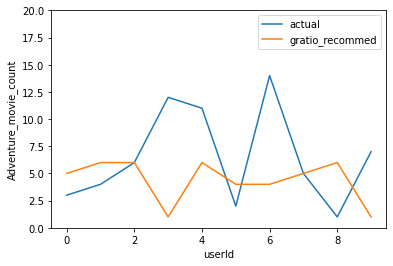

In [44]:
# 사용자와 장르의 그래프
print(cnts['Adventure'],cnts_gratio['Adventure'])
plt.ylim(0,20)
plt.xlabel('userId')
plt.ylabel('Adventure_movie_count')
plt.plot(range(0,10), cnts[:]['Adventure'])
plt.plot(range(0,10), cnts_gratio[:]['Adventure'])
plt.legend(['actual','gratio_recommed'])

In [ ]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

In [ ]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

In [ ]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

In [ ]:
gr_mark=[]
for K in np.arange(1, 11):
    gr_mark.extend([recmetrics.mark(actual, gratio_predictions, k=K)])
gr_mark

In [ ]:
#마땅히 검출해야하는 물체들 중에서 제대로 검출된 것의 비율
mark_scores = [random_mark, pop_mark, cf_mark,gr_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter','Gratio Recommender']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

In [ ]:
catalog = ratings.movieId.unique().tolist()
random_coverage = recmetrics.prediction_coverage(ran_recs, catalog)
pop_coverage = recmetrics.prediction_coverage(pop_recs, catalog)
cf_coverage = recmetrics.prediction_coverage(cf_recs, catalog)
gr_coverage=recmetrics.prediction_coverage(gratio_recs, catalog)

In [ ]:
#plot of prediction coverage 추천시스템이 추천을 해주는 비율
coverage_scores = [random_coverage, pop_coverage, cf_coverage, gr_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter','Gratio Recommender']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

In [ ]:
nov = ratings.movieId.value_counts()
pop = dict(nov)

In [ ]:
compare_pred_df=pd.DataFrame(compare)
recmetrics.class_separation_plot(compare_pred_df, n_bins=45, title="gratio movies compare")
       
            
            

      


In [ ]:
print(mdb)

In [ ]:
idx=list(range(21437))
mdb['index']=idx

In [ ]:
print(mdb)

In [ ]:
compare2=[]
for i in mdb['index']:
    
    modb=mdb[mdb['index']==i]
    ac=modb.iloc[0]['actual']
    cf=modb.iloc[0]['cf_predictions']
    
    if cf>=ac:
        dic=dict()
        dic['predicted']=cf
        dic['truth']=1
        compare2.append(dic)
    else:
        dic=dict()
        dic['predicted']=cf
        dic['truth']=0
        compare2.append(dic)

print(compare2)
        
        
    

In [ ]:
compare_pred_df=pd.DataFrame(compare2)
recmetrics.class_separation_plot(compare_pred_df, n_bins=45, title="comparing ac and cf")

In [ ]:
gratio_recs=[]
mo=pd.read_csv('D:/2021 파일들/1학기 과제 파일들/캡스톤/data/moviedbs.csv')
mo.query('movieId in @rated_movies')



print(mo)


In [ ]:
gratio_recs2=[]
genre_recs=[]
for i in range(0,len(person)):
    gratio=[]
    gen=[]
    for user_id in person[i]:
        gratio_prediction=rate[rate['userId']==user_id-1]
        gratio_prediction=gratio_prediction.sort_values(by=['timestamp'], axis=0,ascending=False )
        gratio_prediction=gratio_prediction.iloc[0]["movieId"]
        mov=mo[mo['movieId']==gratio_prediction]
        for x in mov['genres']:
            
            gen.append(x)
        gratio.append(gratio_prediction)
    
    genre_recs.append(gen)
        
        
    gratio_recs2.append(gratio)

In [ ]:
print(genre_recs)
print(gratio_recs2)

In [ ]:
genresList = [
  "Action",
  "Adventure",
  "Animation",
  "Children",
  "Comedy",
  "Crime",
  "Documentary",
  "Drama",
  "Fantasy",
  "Film-Noir",
  "Horror",
  "Musical",
  "Mystery",
  "Romance",
  "Sci-Fi",
  "Thriller",
    
  "War",
  "Western",
  "(no genres listed)"
]

In [ ]:
def setGenresMatrix(genres):
    movieGenresMatrix = []
    movieGenresList = genres.split('|')
    for x in genresList:
        if (x in movieGenresList):
            movieGenresMatrix.append(1)
        else:
            movieGenresMatrix.append(0) 
    return movieGenresMatrix
mo['genresMatrix'] = mo.apply(lambda x: np.array(list(setGenresMatrix(x['genres']))), axis=1)
mo.head(5)

In [ ]:
genre=[]
for i in genre_recs:
    s="|".join(i)
    print(s)
    genre.append(s)

In [ ]:
df=pd.DataFrame()

for i in genre:
    dic=dict()
    dic['genres']=i
    df=df.append(dic,ignore_index=True)

In [ ]:
df.head()

In [ ]:
df['genresMatrix'] = df.apply(lambda x: np.array(list(setGenresMatrix(x['genres']))), axis=1)

In [ ]:
df.head()

In [ ]:
#test로 뽑힌 영화 중 실제 사용자 시청한 장르 개수 세기.
gen=[]
for cc in movies[movies.index==0]:
    if cc not in gen:
        gen.append(cc)


cnts=pd.DataFrame(None, columns=gen)
tt=[]
for ii in gen:
    tt.append(0)

#print(cnts)
print(df.size)
print(np.array(df.loc[0]['genresMatrix']).tolist())
for i in range(0,10):
    cnts.loc[i]=tt
    for j in actual[i]:
        print(i,"/",j)
        count=0
        for cc in np.array(df.loc[j]['genresMatrix']).tolist():
            try: 
                #print(cc)
                cnts.loc[i][count]=cnts.loc[i][count]+cc
                count+=1
            except:
                #print(j,"번 정보가 없습니다.")
                exception_data.append(j)
                cnts.loc[i]['(no genres listed)']+=1
                break 
            
            

#cnts를 통해 i번째 사용자의 실제 시청 영화 장르의 개수를 센다.
print(cnts)        
           
# 장르가 없는 데이터 리스트
#print(exception_data)



In [ ]:
ngenre=[]
for gen in df['genresMatrix']:
    
    genre=[]
    for x in range(len(gen)):
        if(gen[x]==0):
            genre.append(genresList[x])
    ngenre.append(genre)
        
    
        
    
    

In [ ]:
print(ngenre)

In [ ]:
print(test.index)

In [ ]:
mov=pd.read_csv('c:/moviedb/moviedb.csv')
mov.query('movieId in @rated_movies')
genre_recs=[]
for user in test.index:
    genr=[]
    movie=mov[mov['userId']==user]
    movie=movie.sort_values(by=['timestamp'], axis=0,ascending=False )
    movie=movie[1:10]
    for gen in movie['genres']:
        genr.append(gen)
    genre_recs.append(genr)
        
    

In [ ]:
print(genre_recs)

In [ ]:
genre=[]
for i in genre_recs:
    s="|".join(i)
    print(s)
    genre.append(s)

In [ ]:
dp=pd.DataFrame()

for i in genre:
    dic=dict()
    dic['genres']=i
    dp=dp.append(dic,ignore_index=True)
dp['userId']=test.index

In [ ]:
dp.head()

In [ ]:
dp['genresMatrix'] = dp.apply(lambda x: np.array(list(setGenresMatrix(x['genres']))), axis=1)

In [ ]:
dp.head()

In [ ]:
ngenre=[]
for gen in dp['genresMatrix']:
    
    genre=[]
    for x in range(len(gen)):
        if(gen[x]==0):
            genre.append(genresList[x])
    ngenre.append(genre)

In [ ]:
print(ngenre)

In [ ]:
ng=pd.DataFrame()
ng['user']=test.index
ng['ngenres']=ngenre

In [ ]:
ng.head()

In [ ]:
gratio_recs=[]
mv=pd.read_csv('c:/moviedb/movies.csv')
compare=[]
for i in range(0,len(person)):
    gratio=[]
    
    for user_id in person[i]:
        gratio_prediction=rate[rate['userId']==user_id-1]
        gratio_prediction=gratio_prediction.sort_values(by=['timestamp'], axis=0,ascending=False )
        gmovie=[]
        for mid in gratio_prediction['movieId']:
            ge=mv[mv['movieId']==mid]
            glist=ge['genres']
            glist=glist.str.split('|')
           
            for g in glist:
                for x in g:
                    if x in ngenre[i]:
                        gmovie.append(mid)
        gm=gmovie[0]
        gratio.append(gm)               
           
            
                        
                        
            
        
        
   
    gratio_recs.append(gratio)

In [ ]:
print(gratio_recs)


In [ ]:
test['new_gratio_predictions']=gratio_recs

In [ ]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()
new_gratio_predictions=test.new_gratio_predictions.values.tolist()

In [ ]:
ngr_mark=[]
for K in np.arange(1, 11):
    ngr_mark.extend([recmetrics.mark(actual, new_gratio_predictions, k=K)])
ngr_mark

In [ ]:
mark_scores = [random_mark, pop_mark, cf_mark,gr_mark,ngr_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter','Gratio Recommender','new Gratio Recommender']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)